In [1]:
import os

### openBLAS will not work properly in jupyter notebook
os.environ['OPENBLAS_NUM_THREADS'] = '1'

import pandas as pd
import numpy as np
from scipy import stats as ss
import scipy.sparse as sp

import anndata as ad
import snapatac2 as snap
import scanpy as sc
import anndata
import magic

import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import colors

## Read ccre-by-cell matrices

In [5]:
ac = snap.read("../07.cCREs/MiniAtlas_H3K27ac_snATAC_whole.union.peaks_250601.h5ad", backed = None)
me3 = snap.read("../07.cCREs/MiniAtlas_H3K27me3_snATAC_whole.union.peaks_250601.h5ad", backed = None)

## Calculate H3K27ac enhancer score based on abc links

In [6]:
abci = pd.read_csv("broad_abc_filtcelltype_select_conns.txt", sep = "\t")
badcelltype = ["ENDO", "IMMUNE", "L5ET", "SST-CHODL"]
abcif = abci[~abci["CellType"].isin(badcelltype)]
abcif.shape

(738273, 34)

In [10]:
### summarise all enhancer by genes
map_df = abcif[['TargetGene', 'range']].drop_duplicates()

obj = ac

m = map_df.loc[:, ["range", "TargetGene"]].dropna().copy()

genes = pd.Index(m["TargetGene"].unique(), name="gene")
gene2id = {g: i for i, g in enumerate(genes)}
m["g"] = m["TargetGene"].map(gene2id).astype(np.int64)

r_index = pd.Index(obj.var_names)                       # ranges in your count matrix
m["r"] = r_index.get_indexer(m["range"])               # -1 if not present
m = m[m["r"] >= 0]                                     # drop unmapped ranges

rows = m["r"].to_numpy(np.int64)                       # element (range) indices
cols = m["g"].to_numpy(np.int64)                       # gene indices
data = np.ones(len(rows), dtype=np.float32)            # weight=1 ⇒ sum over ranges

proj = sp.csr_matrix((data, (rows, cols)),
                     shape=(len(r_index), len(genes)))
X_rc = obj.X.T if sp.issparse(obj.X) else sp.csr_matrix(obj.X.T)   # ranges × cells
gene_by_cell = proj.T @ X_rc                                    # genes × cells

print(gene_by_cell.shape)  # (n_genes, n_cells)

(19059, 339097)


In [12]:
adata = ad.AnnData(X=gene_by_cell.T.astype(np.float32), obs=obj.obs.copy(), var=pd.DataFrame(index=genes))
adata

AnnData object with n_obs × n_vars = 339097 × 19059
    obs: 'n_fragment', 'frac_dup', 'frac_mito', 'doublet_probability', 'doublet_score_x', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'percent.ribo', 'doublet_score_y', 'doublet_ident', 'dna', 'rna', 'region', 'structure', 'donor', 'target', 'rna_bc', 'atac_bc', 'index', 'condition', 'leiden', 'subclass', 'subclass_corrected', 'supercluster_manual', 'cluster_manual_name', 'class'

In [15]:
adata.write("MiniAtlas_broad_abc_filtcelltype_select_conn_250901_subclass_corrected_H3K27ac.DORC.h5ad")

... storing 'leiden' as categorical


## Calculate H3K27me3 enhancer score

In [16]:
obj = me3

m = map_df.loc[:, ["range", "TargetGene"]].dropna().copy()
genes = pd.Index(m["TargetGene"].unique(), name="gene")
gene2id = {g: i for i, g in enumerate(genes)}
m["g"] = m["TargetGene"].map(gene2id).astype(np.int64)
r_index = pd.Index(obj.var_names)                       # ranges in your count matrix
m["r"] = r_index.get_indexer(m["range"])               # -1 if not present
m = m[m["r"] >= 0]                                     # drop unmapped ranges

rows = m["r"].to_numpy(np.int64)                       # element (range) indices
cols = m["g"].to_numpy(np.int64)                       # gene indices
data = np.ones(len(rows), dtype=np.float32)            # weight=1 ⇒ sum over ranges

proj = sp.csr_matrix((data, (rows, cols)),
                     shape=(len(r_index), len(genes)))
X_rc = obj.X.T if sp.issparse(obj.X) else sp.csr_matrix(obj.X.T)   # ranges × cells
gene_by_cell = proj.T @ X_rc                                    # genes × cells
adata = ad.AnnData(X=gene_by_cell.T.astype(np.float32), obs=obj.obs.copy(), var=pd.DataFrame(index=genes))
adata

AnnData object with n_obs × n_vars = 411980 × 19059
    obs: 'n_fragment', 'frac_dup', 'frac_mito', 'doublet_probability', 'doublet_score_x', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'percent.ribo', 'doublet_score_y', 'doublet_ident', 'dna', 'rna', 'region', 'structure', 'donor', 'target', 'rna_bc', 'atac_bc', 'index', 'condition', 'leiden', 'subclass', 'subclass_corrected', 'supercluster_manual', 'cluster_manual_name', 'class'

In [62]:
adata.layers["counts"] = adata.X.copy()
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

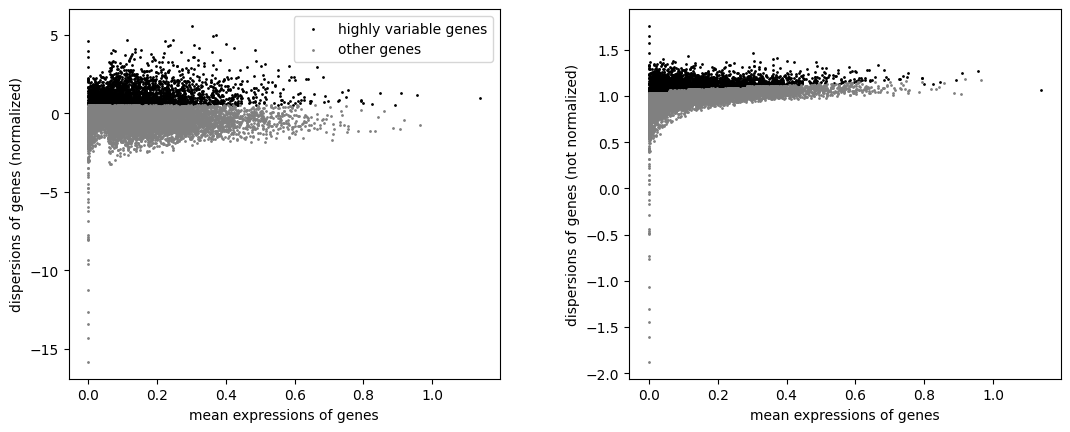

In [63]:
### Select variable genes
sc.pp.highly_variable_genes(adata, n_top_genes=3000)
sc.pl.highly_variable_genes(adata)

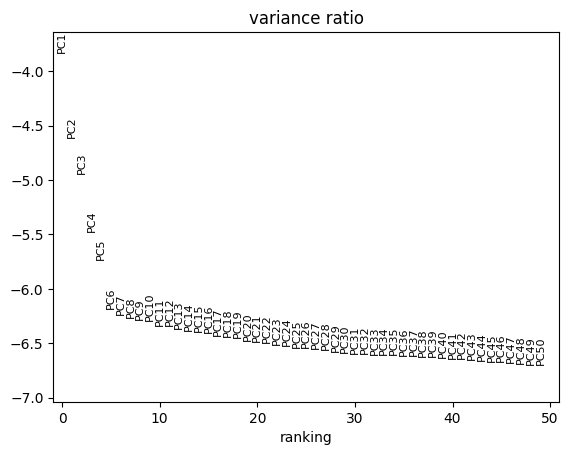

In [64]:
### 1. use var genes only for pca
sc.pp.pca(adata, use_highly_variable = True)
sc.pl.pca_variance_ratio(adata, n_pcs=50, log=True)

In [66]:
sc.external.pp.harmony_integrate(adata, key = 'donor', basis='X_pca', adjusted_basis='X_pca_harmony')

2025-09-12 07:50:27,665 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-09-12 07:50:27 - INFO - Computing initial centroids with sklearn.KMeans...
2025-09-12 07:54:58,224 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-09-12 07:54:58 - INFO - sklearn.KMeans initialization complete.
2025-09-12 07:55:04,081 - harmonypy - INFO - Iteration 1 of 10
2025-09-12 07:55:04 - INFO - Iteration 1 of 10
2025-09-12 07:58:58,871 - harmonypy - INFO - Iteration 2 of 10
2025-09-12 07:58:58 - INFO - Iteration 2 of 10
2025-09-12 08:02:51,658 - harmonypy - INFO - Converged after 2 iterations
2025-09-12 08:02:51 - INFO - Converged after 2 iterations


/home/y2xie/miniconda3/envs/seurat/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:378: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


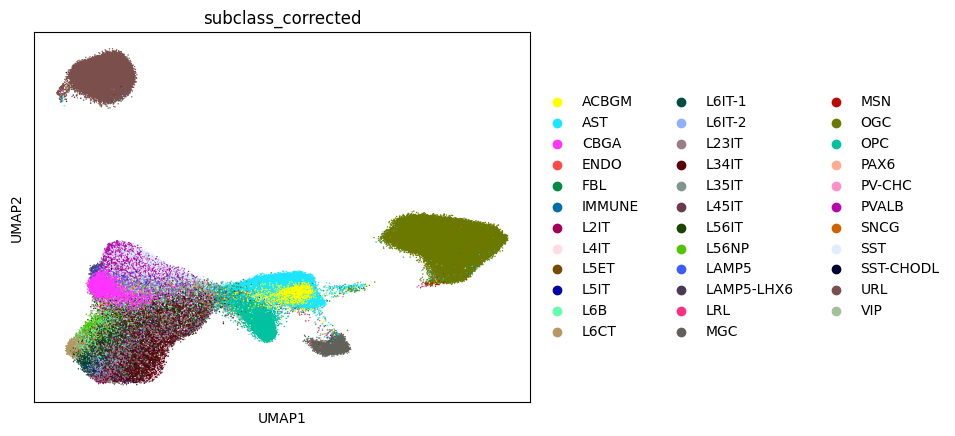

In [67]:
sc.pp.neighbors(adata, use_rep = 'X_pca_harmony')
sc.tl.umap(adata)
sc.pl.umap(
    adata,
    color="subclass_corrected",
    size=4,
)

In [74]:
adata.obsm['X_pca_var'] = adata.obsm['X_pca'].copy()
adata.obsm['X_umap_var'] = adata.obsm['X_umap'].copy()

2025-09-12 08:38:19,419 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-09-12 08:38:19 - INFO - Computing initial centroids with sklearn.KMeans...
2025-09-12 08:42:39,320 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-09-12 08:42:39 - INFO - sklearn.KMeans initialization complete.
2025-09-12 08:42:44,182 - harmonypy - INFO - Iteration 1 of 10
2025-09-12 08:42:44 - INFO - Iteration 1 of 10
2025-09-12 08:46:01,032 - harmonypy - INFO - Iteration 2 of 10
2025-09-12 08:46:01 - INFO - Iteration 2 of 10
2025-09-12 08:50:50,851 - harmonypy - INFO - Iteration 3 of 10
2025-09-12 08:50:50 - INFO - Iteration 3 of 10
2025-09-12 08:52:11,788 - harmonypy - INFO - Converged after 3 iterations
2025-09-12 08:52:11 - INFO - Converged after 3 iterations


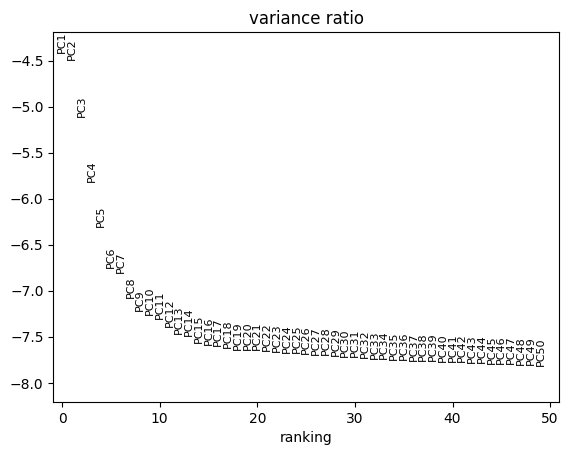

In [77]:
### 2. Use all genes as var for pca
sc.pp.pca(adata, use_highly_variable = False)
sc.external.pp.harmony_integrate(adata, key = 'donor', basis='X_pca', adjusted_basis='X_pca_harmony')

sc.pl.pca_variance_ratio(adata, n_pcs=50, log=True)

/home/y2xie/miniconda3/envs/seurat/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:378: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


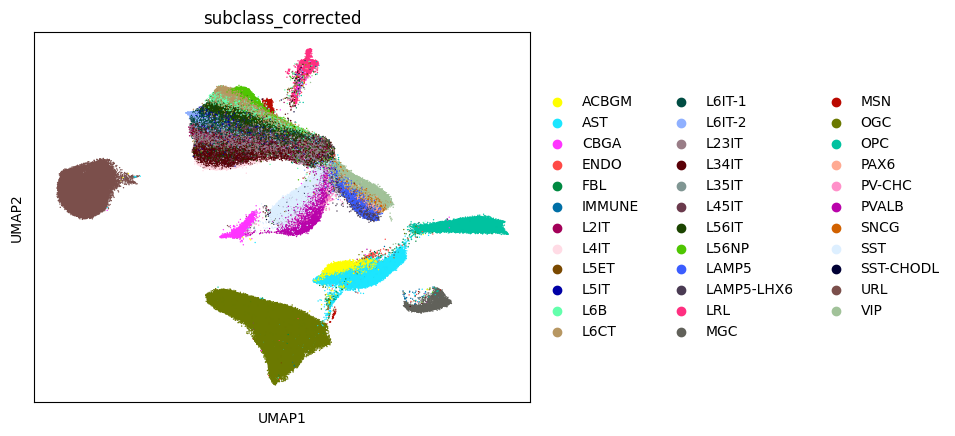

In [78]:
sc.pp.neighbors(adata, use_rep = 'X_pca_harmony')
sc.tl.umap(adata)
sc.pl.umap(
    adata,
    color="subclass_corrected",
    size=4,
)

In [87]:
# adata.var.columns = ['gene', 'highly_variable', 'means', 'dispersions', 'dispersions_norm']
sc.write("MiniAtlas_abc_subclass_corrected_impute_wtss_250901_H3K27ac.DORC.h5ad", adata)

### Process H3K27me3

In [90]:
proj = sp.csr_matrix((data, (rows, cols)),
                     shape=(len(me3.var_names), len(gene2id)))

gene_by_cell = proj.T.dot(me3.X.T)
adata = anndata.AnnData(gene_by_cell.T, obs = me3.obs, var = pd.DataFrame(gene2id.keys(), index=gene2id.keys()))
adata

AnnData object with n_obs × n_vars = 411980 × 12136
    obs: 'n_fragment', 'frac_dup', 'frac_mito', 'doublet_probability', 'doublet_score_x', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'percent.ribo', 'doublet_score_y', 'doublet_ident', 'dna', 'rna', 'region', 'structure', 'donor', 'target', 'rna_bc', 'atac_bc', 'index', 'condition', 'leiden', 'subclass', 'subclass_corrected', 'supercluster_manual', 'cluster_manual_name'
    var: 0

2025-09-12 10:21:41,019 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-09-12 10:21:41 - INFO - Computing initial centroids with sklearn.KMeans...
2025-09-12 10:26:32,418 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-09-12 10:26:32 - INFO - sklearn.KMeans initialization complete.
2025-09-12 10:26:36,532 - harmonypy - INFO - Iteration 1 of 10
2025-09-12 10:26:36 - INFO - Iteration 1 of 10
2025-09-12 10:30:26,109 - harmonypy - INFO - Iteration 2 of 10
2025-09-12 10:30:26 - INFO - Iteration 2 of 10
2025-09-12 10:34:24,844 - harmonypy - INFO - Iteration 3 of 10
2025-09-12 10:34:24 - INFO - Iteration 3 of 10
2025-09-12 10:38:40,060 - harmonypy - INFO - Iteration 4 of 10
2025-09-12 10:38:40 - INFO - Iteration 4 of 10
2025-09-12 10:41:56,057 - harmonypy - INFO - Iteration 5 of 10
2025-09-12 10:41:56 - INFO - Iteration 5 of 10
2025-09-12 10:43:07,289 - harmonypy - INFO - Converged after 5 iterations
2025-09-12 10:43:07 - INFO - Converged after 5

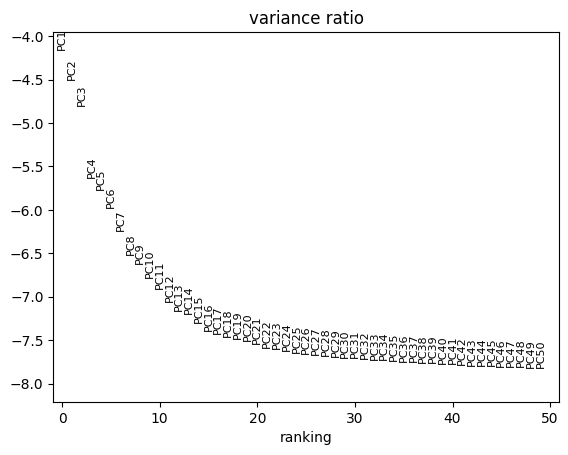

In [91]:
adata.layers["counts"] = adata.X.copy()
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

sc.pp.pca(adata, use_highly_variable = False)
sc.external.pp.harmony_integrate(adata, key = 'donor', basis='X_pca', adjusted_basis='X_pca_harmony')

sc.pl.pca_variance_ratio(adata, n_pcs=50, log=True)

/home/y2xie/miniconda3/envs/seurat/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:378: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


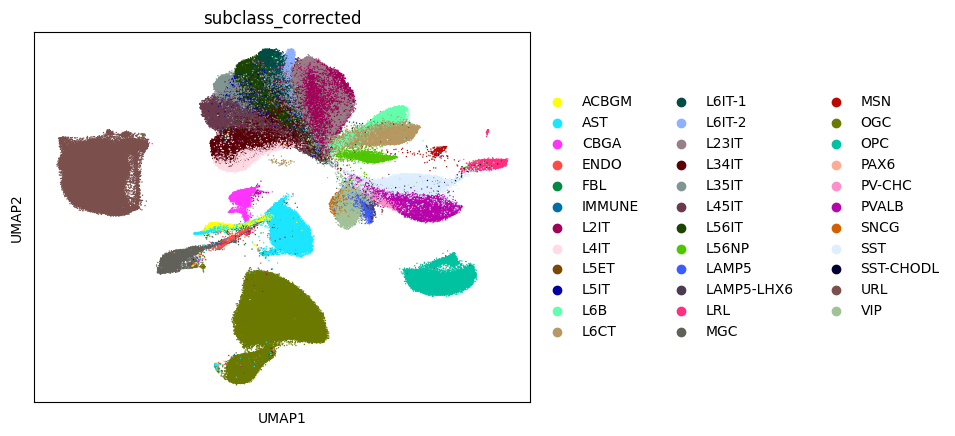

In [92]:
sc.pp.neighbors(adata, use_rep = 'X_pca_harmony')
sc.tl.umap(adata)
sc.pl.umap(
    adata,
    color="subclass_corrected",
    size=4,
)

In [96]:
adata.var.columns = ['gene']
sc.write("MiniAtlas_abc_subclass_corrected_impute_wtss_250901_H3K27me3.DORC.h5ad", adata)